## Import Module

In [1]:
import os
import skimage.io as io
import sys
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Module_path = os.path.join(os.path.dirname(os.getcwd()), 'Mask_RCNN')
sys.path.append(Module_path)

In [2]:
from config import Config
import utils
import model as modellib
import visualize
from model import log
import prostate
import visualize
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
     create_pairwise_gaussian, softmax_to_unary

Using TensorFlow backend.


## Configurations

In [3]:
# Specify the dir that store the prostate dataset
dataset_dir = os.path.join(os.path.dirname(os.getcwd()), "Data_Pre_Processing/cedars-224")
# We do 5-fold validation, specify which fold to be exclude for the current run
held_out_set = 4
# Featch the mean_pixel based on the training data (data exclude the held_out_set)
mean_pixel = prostate.Mean_pixel(dataset_dir, held_out_set)
# Configuration
class PostProcessingConfig(prostate.ProstateConfig):
    IMAGE_MAX_DIM = 1024
    IMAGE_MIN_DIM = 1024
    MODE = -1
postprocessing_config = PostProcessingConfig()
postprocessing_config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.99
GPU_COUNT                      1
IMAGES_PER_GPU                 4
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
MODE                           -1
NAME                           prostate
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INF

## Prepare the Dataset and Specify the Interested Image

In [4]:
Image_list = [207]
dataset = prostate.ProstateDataset()
dataset.load_prostate(dataset_dir, Image_list, mode = postprocessing_config.MODE)
dataset.prepare()

## Load Image, Ground Truth Mask and Probability Map

In [5]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, postprocessing_config,
                               0, use_mini_mask=False)
gt_sementic_mask = utils.instance_2_sementic(gt_mask, gt_class_id)
gt_sementic_mask = gt_sementic_mask['ATmask']
prob = dataset.load_prob_map(0)

In [6]:
# change the prob (0, 0, 0, 0) item to (1, 0, 0 ,0)
index_0, index_1 = np.where((prob == (0, 0, 0, 0)).all(axis = 2))
prob[index_0, index_1, :] = (0.99, 0.0003, 0.0003, 0.0003)

## Conditional Random Field

In [7]:
# move the probability axis to assure that the first dimension is the class dimension
prob_move = np.moveaxis(prob, 2, 0)
# The input should be the negative of the logarithm of probability values
# Look up the definition of the softmax_to_unary for more information
unary = softmax_to_unary(prob_move)
# The inputs should be C-continious -- we are using Cython wrapper
unary = np.ascontiguousarray(unary)

In [8]:
d = dcrf.DenseCRF(image.shape[0] * image.shape[1], 4)
d.setUnaryEnergy(unary)

In [9]:
# This potential penalizes small pieces of segmentation that are
# spatially isolated -- enforces more spatially consistent segmentations
feats = create_pairwise_gaussian(sdims=(10, 10), shape=image.shape[:2])
d.addPairwiseEnergy(feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

In [10]:
# This creates the color-dependent features --
# because the segmentation that we get from CNN are too coarse
# and we can use local color features to refine them
feats = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20),
                                   img=image, chdim=2)
d.addPairwiseEnergy(feats, compat=10,
                     kernel=dcrf.DIAG_KERNEL,
                     normalization=dcrf.NORMALIZE_SYMMETRIC)

In [11]:
Q = d.inference(5)
res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

## Visualization

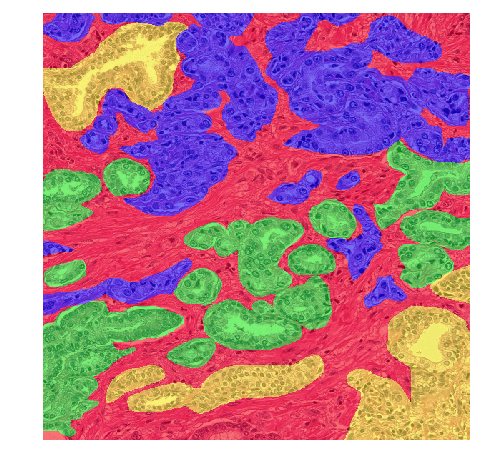

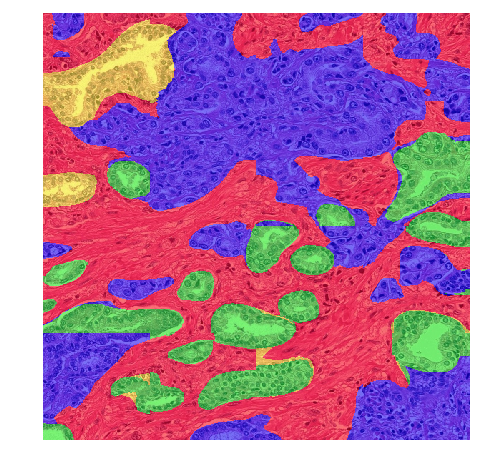

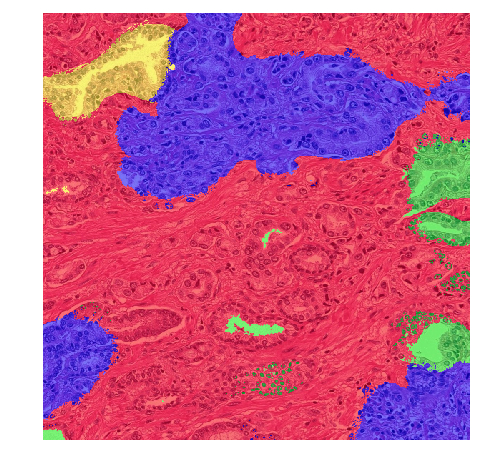

In [12]:
# Visualization the sementic map
visualize.display_sementic(image, gt_sementic_mask,
                            figsize=(8, 8))
visualize.display_sementic(image, np.argmax(prob, axis = -1),
                            figsize=(8, 8))
visualize.display_sementic(image, res,
                            figsize=(8, 8))